## PART 2: Customer Cohort Analysis

Based on our analysis in part 1, we concluded that the Q4-2021 revenue spike was due to a significant increase in demand for computer hardware during that period.

In part 2, we will perform a time cohort analysis to identify the customer segments that increased their order size, subsequently increasing business revenue. This analysis should be another important insight on how the business can capitalize on this trend.

In short, Cohort Analysis is a type of analysis that groups customers by their initial purchase date and then tracks their behavior and purchases over time. It provides insights into customer retention, loyalty, and trends over time.

In [1]:
import pandas as pd
from pandasql import sqldf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

### 2.1 Preparing Data

To prepare the data for cohort analysis, we can take the following steps:

1. Group the sales data by customer_code
2. Calculate the month difference between the customer's first purchase and all of the customer's invoice dates, which will output the month number of each subsequent transaction after the first purchase.
3. Pivot the table so that the index shows the cohort date, the columns show the number of months since the first purchase, and the values show the number of active customers in that cohort for each month.

In [2]:
#Data Transformation
salesdata = pd.read_csv('Sales_domain.csv', encoding='ISO-8859-1')
salesdata['Date'] = pd.to_datetime(salesdata['Date'], format='%d-%m-%Y')
salesdata['customer_code'] = salesdata['customer_code'].astype(str)

In [3]:
sqlquery = """
WITH cohortmonth AS (
SELECT 
    customer_code,
    strftime('%Y-%m-%d', MIN(Date)) AS cohortdate
FROM salesdata
GROUP BY customer_code)

SELECT 
    df.Date AS invoicedate,
    df.customer_code AS customer_code,
    df.sold_quantity AS sold_quantity,
    cdf.cohortmonth AS cohortdate
FROM salesdata AS df
LEFT JOIN cohortmonth AS cdf
    ON df.customer_code = cdf.customer_code
"""

In [4]:
df_customer_cohort = salesdata.copy()
df_customer_cohort['invoicedate'] = df_customer_cohort['Date'].apply(lambda x: dt.datetime(x.year, x.month, 1))
grouping = df_customer_cohort.groupby('customer_code')['invoicedate']
df_customer_cohort['cohortdate'] = grouping.transform('min')

In [5]:
df_customer_cohort.head(10)

,Date,product_code,customer_code,sold_quantity,fiscal_year,division,segment,category,product,variant,customer,platform,channel,market,sub_zone,region,gross_price,cost_year,manufacturing_cost,pre_invoice_discount_pct,invoicedate,cohortdate
0,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2018,4.6190,0.0824,2017-09-01,2017-09-01
1,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2019,4.2033,0.0824,2017-09-01,2017-09-01
2,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2020,5.0207,0.0824,2017-09-01,2017-09-01
3,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,15.3952,2021,5.5172,0.0824,2017-09-01,2017-09-01
4,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2018,4.6190,0.0824,2017-09-01,2017-09-01
5,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2019,4.2033,0.0824,2017-09-01,2017-09-01
6,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2020,5.0207,0.0824,2017-09-01,2017-09-01
7,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,14.4392,2021,5.5172,0.0824,2017-09-01,2017-09-01
8,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,16.2323,2018,4.6190,0.0824,2017-09-01,2017-09-01
9,2017-09-01,A0118150101,70002017,51,2018,P & A,Peripherals,Internal HDD,AQ Dracula HDD  3.5 Inch SATA 6 Gb/s 5400 RPM...,Standard,Atliq Exclusive,Brick & Mortar,Direct,India,India,APAC,16.2323,2019,4.2033,0.0824,2017-09-01,2017-09-01


**Remark:** The pandasSQL code has encountered an irreparable issue. Therefore, we will display the SQL code as a reference, but this section will use Python and Pandas to transform the data for cohort analysis.

In [6]:
df_customer_cohort['invoicedate'] = pd.to_datetime(df_customer_cohort['invoicedate'])
df_customer_cohort['cohortdate'] = pd.to_datetime(df_customer_cohort['cohortdate'])

In [7]:
def get_date_num(df,col):
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    return year, month, day

In [8]:
def get_monthdiff(df,invoice,cohort):
    invoice_year, invoice_month, _ = get_date_num(df, invoice)
    cohort_year, cohort_month, _ = get_date_num(df, cohort)
    year_diff = (invoice_year - cohort_year) * 12
    month_diff = (invoice_month - cohort_month) + 1
    return year_diff + month_diff
    

In [9]:
monthdiff = get_monthdiff(df_customer_cohort,'invoicedate','cohortdate')

In [10]:
df_customer_cohort['cohortindex'] = monthdiff

In [11]:
group = df_customer_cohort.groupby(['cohortdate', 'cohortindex'])
cohort_data = group['customer_code'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()

In [12]:
cohort_data = cohort_data.pivot(index='cohortdate', columns='cohortindex', values='customer_code')

The resulting table will display the customer acquisition date as the index, the number of months since acquisition in the table columns, and the number of active customers as the values. For instance, a customer acquired by the company in September 2017 has a total of 84 clients, and after 2 months of becoming a customer, 51 of them are active.

It's important to cross-check the results with the actual sales data. In Part 1, it was observed that new customers were acquired around September of 2018 and 2019. Therefore, the correct cohort data would report only those dates as the periods when new customers were gained. 

In [13]:
cohort_data

cohortindex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
cohortdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-01,84.0,51.0,50.0,49.0,75.0,51.0,50.0,49.0,75.0,51.0,50.0,49.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0,84.0,57.0,56.0,55.0
2017-10-01,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN,25.0,25.0,25.0,NaN
2018-09-01,36.0,23.0,24.0,25.0,36.0,23.0,24.0,25.0,36.0,23.0,24.0,25.0,36.0,23.0,24.0,25.0,36.0,23.0,23.0,24.0,35.0,23.0,24.0,25.0,36.0,23.0,24.0,25.0,36.0,23.0,24.0,25.0,36.0,23.0,24.0,25.0,36.0,23.0,24.0,25.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,15.0,15.0,15.0,NaN,15.0,15.0,15.0,NaN,15.0,15.0,15.0,NaN,15.0,15.0,15.0,NaN,15.0,14.0,14.0,NaN,15.0,15.0,15.0,NaN,15.0,15.0,15.0,NaN,15.0,15.0,15.0,NaN,15.0,15.0,15.0,NaN,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,37.0,25.0,25.0,24.0,37.0,25.0,19.0,20.0,31.0,20.0,25.0,24.0,37.0,25.0,25.0,24.0,37.0,25.0,25.0,24.0,37.0,25.0,25.0,24.0,37.0,25.0,25.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,12.0,12.0,12.0,NaN,12.0,9.0,11.0,NaN,11.0,12.0,12.0,NaN,12.0,12.0,12.0,NaN,12.0,12.0,12.0,NaN,12.0,12.0,12.0,NaN,12.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.2 Customer Retention Cohort

Let's examine the customer retention rate to understand the consistency of business clients throughout the year.

To calculate the retention rate of each cohort, we can simply take the first column, which represents the total customers that the company acquired during that period, and divide it by the remaining columns to obtain the retention rates of each month period.

In [14]:
cohort_size = cohort_data.iloc[:,0]

In [15]:
cohort_size

cohortdate
2017-09-01    84.0
2017-10-01    25.0
2018-09-01    36.0
2018-10-01    15.0
2019-09-01    37.0
2019-10-01    12.0
Name: 1, dtype: float64

In [16]:
cohort_data_retention = cohort_data.divide(cohort_size, axis=0)
cohort_data_retention = cohort_data_retention.round(3)*100

In [17]:
cohort_data_retention

cohortindex,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52
cohortdate,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-09-01,100.0,60.7,59.5,58.3,89.3,60.7,59.5,58.3,89.3,60.7,59.5,58.3,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5,100.0,67.9,66.7,65.5
2017-10-01,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN
2018-09-01,100.0,63.9,66.7,69.4,100.0,63.9,66.7,69.4,100.0,63.9,66.7,69.4,100.0,63.9,66.7,69.4,100.0,63.9,63.9,66.7,97.2,63.9,66.7,69.4,100.0,63.9,66.7,69.4,100.0,63.9,66.7,69.4,100.0,63.9,66.7,69.4,100.0,63.9,66.7,69.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-01,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,93.3,93.3,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,100.0,67.6,67.6,64.9,100.0,67.6,51.4,54.1,83.8,54.1,67.6,64.9,100.0,67.6,67.6,64.9,100.0,67.6,67.6,64.9,100.0,67.6,67.6,64.9,100.0,67.6,67.6,64.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-01,100.0,100.0,100.0,NaN,100.0,75.0,91.7,NaN,91.7,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,100.0,100.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**_2.2.1 Heatmap: Retention Rate**

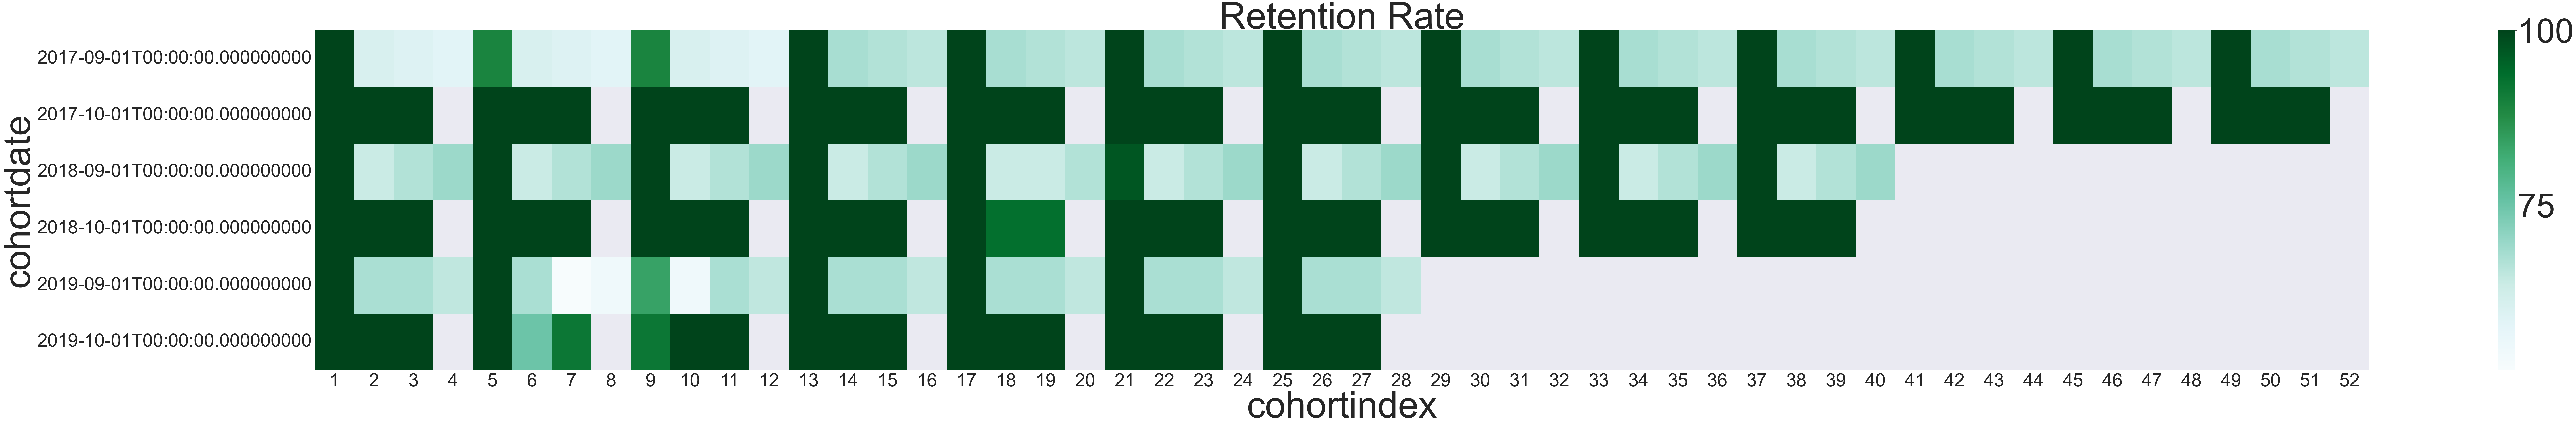

In [40]:
plt.figure(figsize=(150,20))
plt.title('Retention Rate')
sns.heatmap(data=cohort_data_retention, annot=False, fmt='.0%', cmap='BuGn',annot_kws={"size": 60})
plt.xticks(fontsize=60)
plt.yticks(fontsize=60, rotation=0)
sns.set(font_scale=20)

**Observations:**
- Despite not acquiring any new customers in the last two years of the data, the business has a positive retention rate with no customer groups having less than 50% retention rates. Moreover, the customers in the cohort that were acquired in the 10th month appear to be very loyal, with a 100% retention rate in most months.
- The cohorts acquired in September every year show a full retention rate every five months or so, while the cohorts acquired in October seem to be entirely inactive every four months.

## 2.3 Product Quantity Cohort

Next, to validate the assumption that the increase in Q4 2021 revenue was due to an increase in product demand and to identify the customer group with a higher product demand, we can examine the sold quantity of each cohort. By doing so, we can identify which customer segment suddenly ordered more of our products.

In [19]:
product_group = df_customer_cohort.groupby(['cohortdate', 'cohortindex'])
product_cohort_data = group['sold_quantity'].mean()
product_cohort_data = product_cohort_data.reset_index()
product_cohort_data

,cohortdate,cohortindex,sold_quantity
0,2017-09-01,1,17.334580
1,2017-09-01,2,24.171102
2,2017-09-01,3,34.235931
3,2017-09-01,4,35.641143
4,2017-09-01,5,19.056671
...,...,...,...
205,2019-10-01,22,15.971717
206,2019-10-01,23,16.116667
207,2019-10-01,25,92.508145
208,2019-10-01,26,124.501253


In [20]:
product_cohort_data = product_cohort_data.pivot(index='cohortdate', columns='cohortindex', values='sold_quantity')

In [21]:
product_cohort_data = product_cohort_data.round()

**_2.2.2 Heatmap: Quantity_sold**

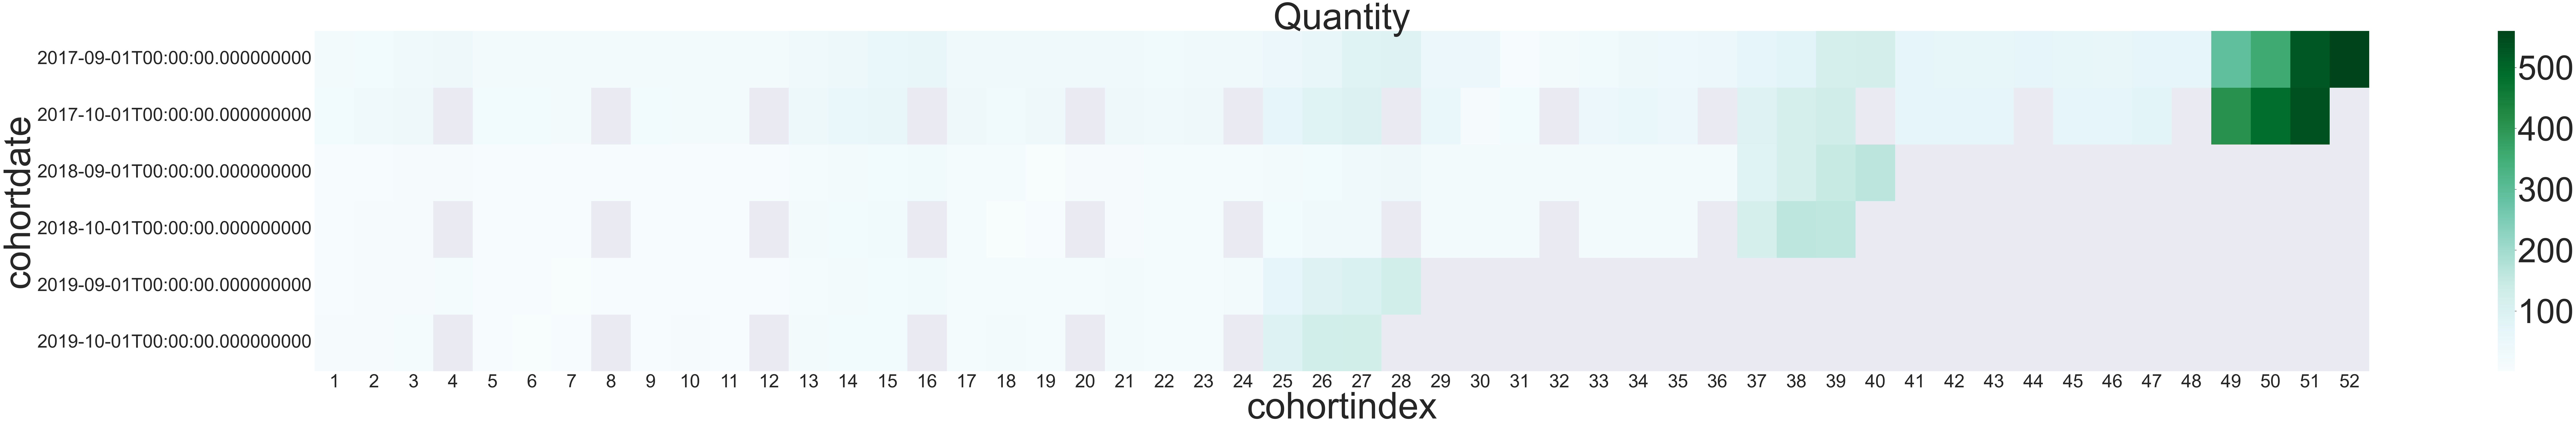

In [43]:
plt.figure(figsize=(150,20))
plt.title('Quantity')
sns.heatmap(data=product_cohort_data, annot=False, cmap='BuGn',annot_kws={"size": 60})
plt.xticks(fontsize=60)
plt.yticks(fontsize=60, rotation=0)
sns.set(font_scale=5)

**Based on the cohort analysis of sold quantities:**
- It appears that the customers acquired in 2017 have recently increased their order size substantially. This observation supports the prior conclusion that longtime existing customers likely played a significant role in the increase in demand for computer hardware. 
- Additionally, it appears that customers acquired in later years have also increased their order size, although not to the same extent as the 2017 customer base. Overall, this indicates a general increase in market demand for the product.

**Based on the cohort analysis and the exploration of demand in each market location (from EDA, part1), we can make the following observations:**

- The demand has significantly increased among clients that have been doing business with the company since the start of the dataset or before the start of the dataset. It is unclear whether these customers were acquired in 2017 or if they were existing customers that predate the dataset.
- However, regardless of their acquisition date, these customers count as existing customers with long tenure.
- Remember that, Most of the big market locations also experienced an increase in demand.
- It is possible that clients who have a long-standing partner-like relationship with the business are more likely to order more supply in larger sizes when they experience demand from their own customers. In contrast, newly acquired customers may be more hesitant to place large orders with a new supplier.